In [ ]:
!pip install fairpredictor==0.0.39

contextily added for basemap visualization



In [ ]:
!pip install onnxruntime contextily

In [ ]:
from predictor import predict

Raster2polygon is not installed. This option won't be available in postprocessing


## Download Your local model

---

- You can either go to fair-dev.hotosm.org and download your model manually or you can use API to fetch the model programmatically
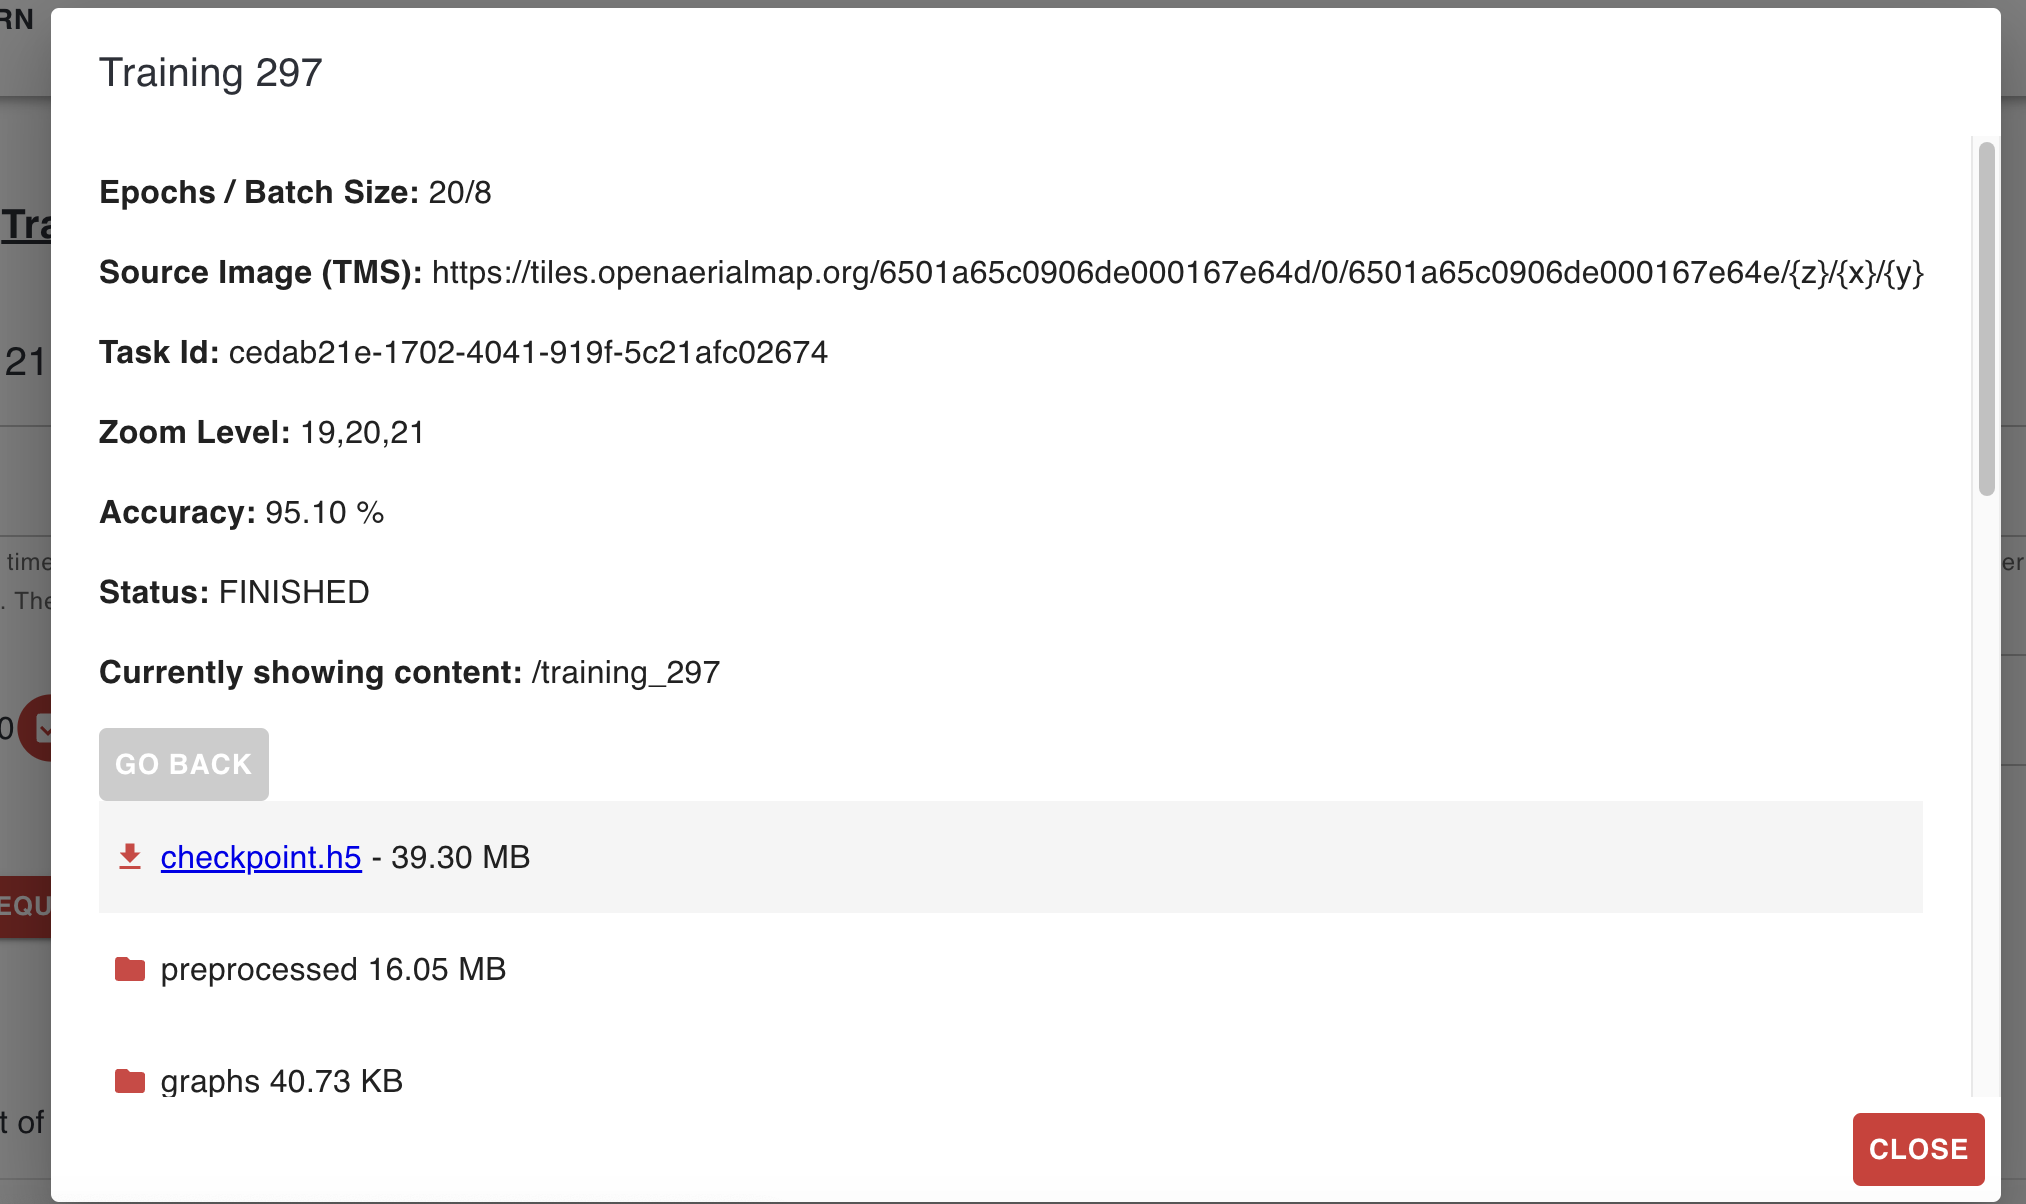

In [ ]:
import pandas as pd

benchmark_df = pd.read_csv('https://raw.githubusercontent.com/hotosm/fAIr-utilities/refs/heads/master/docs/benchmark/training_datasets.csv')
benchmark_df


,id,id_model,id_train,ds_size,urban_region,country,continent,id_dataset,urban_type,density,roof_type,Unnamed: 11
0,1,51,364,399,Kakuma,Kenya,Africa,58,refugee camp,sparse,metal,NaN
1,2,95,370,168,Denver,USA,America North,135,peri-urban,grid,shingles,NaN
2,3,97,372,420,Montevideo,Uruguay,America South,137,urban,grid,cement,NaN
3,4,98,373,399,Montevideo dense,Uruguay,America South,138,urban,dense,cement,NaN
4,5,102,391,231,Kutupalong,Bangladesh,Asia,144,refugee camp,dense,mixed,NaN
5,6,110,394,504,Gornja Rijeka,Croatia,Europe,157,rural,sparse,shingles,NaN
6,7,112,397,756,Melbourne,Australia,Oceania,171,urban,grid,cement,NaN
7,8,113,398,152,Pemba,Tanzania,Africa,170,rural,sparse,metal,NaN
8,9,114,399,294,Christchurch,New Zealand,Oceania,177,peri-urban,sparse,shingles,NaN
9,10,134,456,147,Pergamino,Argentina,America South,197,peri-urban,grid,mixed,NaN


In [ ]:
import pandas as pd, requests, shutil, json
import geopandas as gpd, matplotlib.pyplot as plt, contextily as ctx

def get_local_model_details(training_id, verbose=False):
    base = "https://fair-dev.hotosm.org"
    try:
        # Fetch model details
        model_resp = requests.get(f"{base}/api/v1/workspace/training_{training_id}")
        model_resp.raise_for_status()
        model_details = model_resp.json()
        if verbose:
          print(model_details)

        # Download checkpoint (tflite or onnx) , tflite is for tf models (ramp) and onnx is for torch models (yolo)
        files = model_details.get("file", {})
        file_key = "checkpoint.tflite" if "checkpoint.tflite" in files else ("checkpoint.onnx" if "checkpoint.onnx" in files else None)
        checkpoint_file = None
        if file_key:
            chkpt_resp = requests.get(f"{base}/api/v1/workspace/download/training_{training_id}/{file_key}", stream=True)
            chkpt_resp.raise_for_status()
            checkpoint_file = f"training_{training_id}_{file_key}"
            with open(checkpoint_file, 'wb') as f:
                shutil.copyfileobj(chkpt_resp.raw, f)
            print(f"Checkpoint downloaded: {checkpoint_file}")
        else:
            print("No checkpoint file found.")

        # Fetch training details
        train_resp = requests.get(f"{base}/api/v1/training/{training_id}/")
        train_resp.raise_for_status()
        training_details = train_resp.json()

        # Download AOIs GeoJSON if available
        aois_gdf = None
        if "aois.geojson" in files:
            aois_resp = requests.get(f"{base}/api/v1/workspace/download/training_{training_id}/aois.geojson")
            aois_resp.raise_for_status()
            geojson_file = f"training_{training_id}_aois.geojson"
            with open(geojson_file, "wb") as f:
                f.write(aois_resp.content)
            aois_gdf = gpd.read_file(geojson_file)

        if verbose:
          # Print details
          print("Training Details:\n", json.dumps(training_details, indent=2))
          print("\nModel Details:\n", json.dumps(model_details, indent=2))

        # Create summary DataFrame
        summary = {
            "training_id": training_id,
            "accuracy": training_details.get("accuracy"),
            "status": training_details.get("status"),
            "epochs": training_details.get("epochs"),
            "source_imagery": training_details.get("source_imagery"),
            "checkpoint_file": checkpoint_file,
            "aois_exists": aois_gdf is not None,
            "aois_geojson": geojson_file
        }


        # Plot AOIs if available
        if aois_gdf is not None and not aois_gdf.empty:
            if not aois_gdf.crs:
                aois_gdf.set_crs(epsg=4326, inplace=True)
            aois_gdf = aois_gdf.to_crs(epsg=3857)
            fig, ax = plt.subplots(figsize=(10, 10))
            aois_gdf.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2)
            src = training_details.get("source_imagery")
            if src: ctx.add_basemap(ax, source=src)
            ax.set_axis_off(); plt.title(f"Training Area for Model training ID {training_id}"); plt.show()

        return summary

    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
        return None
    except Exception as e:
        print(f"Error: {e}")
        raise


Checkpoint downloaded: training_364_checkpoint.tflite


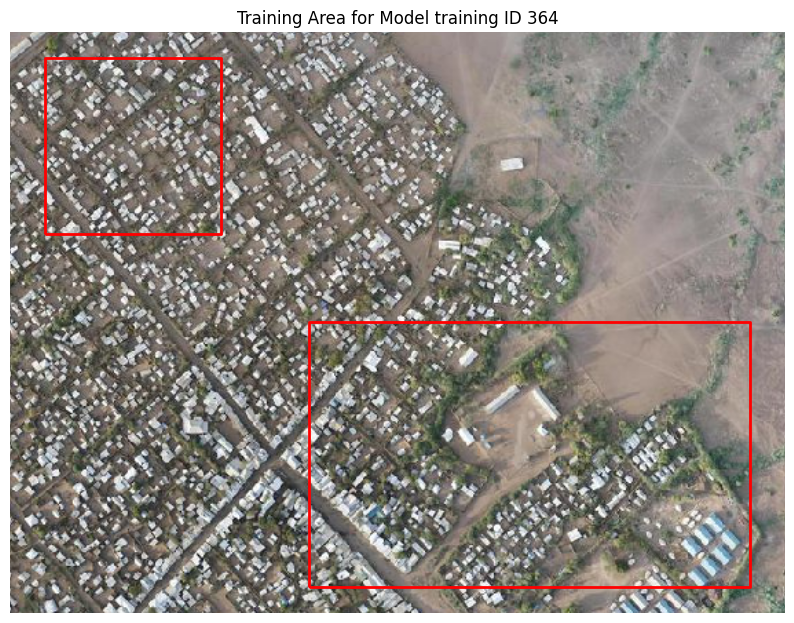

In [ ]:
training_info = get_local_model_details(364)

**Parameters**
* **bbox** : Bounding box of the area you want to run prediction on
* **model_path** : Path of your downloaded model checkpoint
* **zoom_level** : Zoom level of the tiles to be used for prediction
* **tms_url** : Your Image URL on which you want to detect feature

In [ ]:
print(training_info)

{'training_id': 364, 'accuracy': 97.6, 'status': 'FINISHED', 'epochs': 20, 'source_imagery': 'https://tiles.openaerialmap.org/64b24336f1006f000147af2d/0/64b24336f1006f000147af2e/{z}/{x}/{y}', 'checkpoint_file': 'training_364_checkpoint.tflite', 'aois_exists': True, 'aois_geojson': 'training_364_aois.geojson'}


## Random bounding box for prediction

we are generating random bbox for now , but make sure bbox is outside of the training area for better evaluation

In [ ]:
import random
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

def generate_random_bbox(details, visualize=False):
    aoi_geojson = details.get("aois_geojson")
    if not aoi_geojson:
        raise ValueError("AOI geojson path not provided in details.")
    aoi_gdf = gpd.read_file(aoi_geojson)
    if aoi_gdf.crs is None:
        aoi_gdf.set_crs(epsg=4326, inplace=True)
    local_crs = aoi_gdf.estimate_utm_crs()
    minx, miny, maxx, maxy = aoi_gdf.total_bounds
    max_attempts = 100
    for _ in range(max_attempts):
        scale_x = random.uniform(0.2, 0.8)
        scale_y = random.uniform(0.2, 0.8)
        bbox_width = (maxx - minx) * scale_x
        bbox_height = (maxy - miny) * scale_y
        center_x = random.uniform(minx + bbox_width/2, maxx - bbox_width/2)
        center_y = random.uniform(miny + bbox_height/2, maxy - bbox_height/2)
        bbox_minx = center_x - bbox_width/2
        bbox_miny = center_y - bbox_height/2
        bbox_maxx = center_x + bbox_width/2
        bbox_maxy = center_y + bbox_height/2
        bbox = (bbox_minx, bbox_miny, bbox_maxx, bbox_maxy)
        bbox_geom = box(*bbox)
        bbox_geom_proj = gpd.GeoSeries([bbox_geom], crs=aoi_gdf.crs).to_crs(local_crs).iloc[0]
        aoi_union = aoi_gdf.unary_union
        aoi_union_proj = gpd.GeoSeries([aoi_union], crs=aoi_gdf.crs).to_crs(local_crs).iloc[0]
        intersection = bbox_geom_proj.intersection(aoi_union_proj)
        overlap_ratio = intersection.area / bbox_geom_proj.area if bbox_geom_proj.area > 0 else 0
        if overlap_ratio <= 0.2:
            break
    else:
        raise ValueError("Could not generate a bbox meeting the overlap criteria after {} attempts.".format(max_attempts))
    if visualize:
        bbox_gdf = gpd.GeoDataFrame({"geometry": [bbox_geom]}, crs=aoi_gdf.crs)
        aoi_plot = aoi_gdf.to_crs(epsg=3857)
        bbox_plot = bbox_gdf.to_crs(epsg=3857)
        fig, ax = plt.subplots(figsize=(10, 10))
        aoi_plot.boundary.plot(ax=ax, edgecolor="red", linewidth=2, label="AOI")
        bbox_plot.boundary.plot(ax=ax, edgecolor="blue", linewidth=2, label="Random BBox")
        imagery_source = details.get("source_imagery")
        if imagery_source:
            ctx.add_basemap(ax, source=imagery_source)
        ax.legend()
        ax.set_title("AOI and Random Bounding Box")
        ax.set_axis_off()
        plt.show()
    return bbox


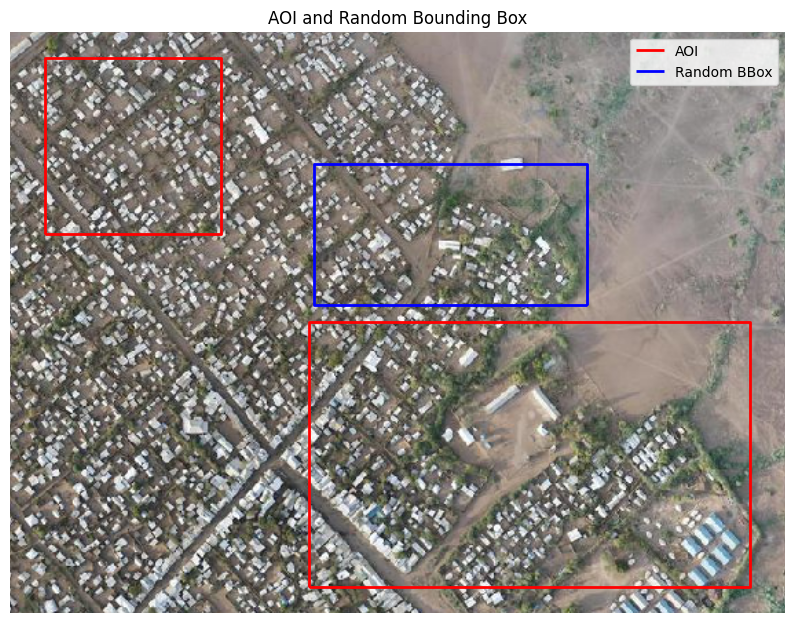

In [ ]:
bbox=generate_random_bbox(training_info, visualize=True)
model_path=training_info['checkpoint_file']
zoom_level=19
tms_url=training_info['source_imagery']


In [ ]:
bbox

(34.82463461450781, 3.7691572904068336, 34.826766419823734, 3.770254275341995)

## Actual Predictions
This is where actual predictions gonna be , Here if you set remote_metadata to false it will generate the predictions mask and vectorization for each tile which will help working on postprocessing

In [ ]:
my_predictions=predict(bbox,model_path,zoom_level,tms_url,remove_metadata=False)
print(my_predictions)

Download starting from [312861, 256650] to [312864, 256649] using source https://tiles.openaerialmap.org/64b24336f1006f000147af2d/0/64b24336f1006f000147af2e/{z}/{x}/{y} - 19
Using : training_364_checkpoint.tflite
TFlite_runtime is not installed.
It took 0 sec to load model
It took 4 sec to predict with 0.5 Confidence Threshold


Georeferencing for prediction:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Georeferencing for prediction: 100%|██████████| 8/8 [00:00<00:00, 184.14it/s]

It took 0 sec to georeference


It took 0 sec to extract polygons
{'type': 'FeatureCollection', 'name': 'prediction', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}, 'features': [{'type': 'Feature', 'properties': {'level_0': 0, 'level_1': 0, 'building': 'yes', 'source': 'fAIr'}, 'geometry': {'type': 'Polygon', 'coordinates': [[[34.82500547541185, 3.770394242436629], [34.82501086088414, 3.770380807896849], [34.82502971003718, 3.770388868620742], [34.82502971003718, 3.770394242436629], [34.82500547541185, 3.770394242436629]]]}}, {'type': 'Feature', 'properties': {'level_0': 3, 'level_1': 0, 'building': 'yes', 'source': 'fAIr'}, 'geometry': {'type': 'Polygon', 'coordinates': [[[34.824822369353846, 3.770394242436629], [34.82484391124302, 3.770361999540809], [34.8248654531322, 3.770372747172882], [34.82485737492376, 3.770394242436629], [34.824822369353846, 3.770394242436629]]]}}, {'type': 'Feature', 'properties': {'level_0': 4, 'level_1': 0, 'building': 'yes', 'source': 'fAIr'}, 'geometry

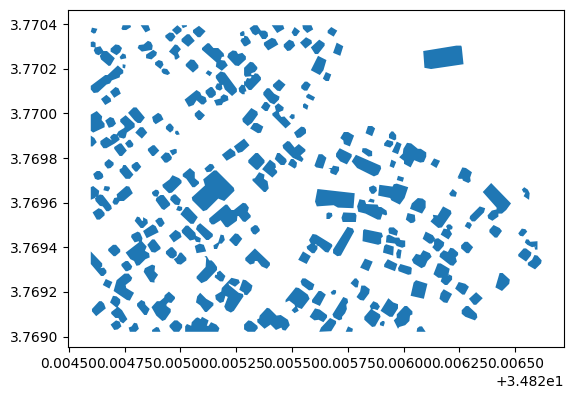

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
gdf = gpd.GeoDataFrame.from_features(my_predictions)
gdf.plot()
plt.show()